In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(123)
from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

/home/neptun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Create Data for Features

In [22]:
import imageio
import pickle
import pandas as pd
import numpy as np
from random import randint
from random import seed
with open('Complete_features_DF_AR-DP1C_DP104_001_001-20180124-1322595', 'rb') as handle:
    cfdf = pickle.load(handle)
name=list(cfdf)
cfdfx=cfdf[name[0]]

for i in range(1,len(name),1):
    x1=cfdf[name[i]]
    cfdfx=pd.concat([cfdfx,x1], axis=1)
with open('features_Speedload_AR-DP1C_DP104_001_001-20180124-132259', 'rb') as handle:
    sldf = pickle.load(handle)
    
    
speed=list(sldf)
#print(speed)
x=sldf[speed[0]]
x=pd.DataFrame(data=x)
for i in range(1,len(speed),1):
    n=sldf[speed[i]]
    x[speed[i]]=n

dfnew = x.rename(columns={0 : str(speed[0])})

cfdfx=pd.concat([cfdfx,dfnew], axis=1)
cfdfx.head()
cfdfx = cfdfx[:-1]
cfdfx.shape



(163, 243)

In [23]:
def write_dataset(sensor_features='Complete_features_DF_AR-DP1C_DP104_001_001-20180124-1322595',
                 speedload_features='features_Speedload_AR-DP1C_DP104_001_001-20180124-132259',
                 label=1):
############ Fail features
    import imageio
    import pickle
    import pandas as pd
    import numpy as np
    from random import randint
    from random import seed
    with open(sensor_features, 'rb') as handle:
        cfdf = pickle.load(handle)

    name=list(cfdf)
    cfdfx=cfdf[name[0]]

    for i in range(1,len(name),1):
        x1=cfdf[name[i]]
        cfdfx=pd.concat([cfdfx,x1], axis=1)

    #cfdfx = pd.concat([df for df in cfdf.values()], ignore_index=True)

    cfdfx.head(n=5)  # visualize the data.

    with open(speedload_features, 'rb') as handle:
        sldf = pickle.load(handle)

    # print(sldf)

    speed=list(sldf)

    x=sldf[speed[0]]
    x=pd.DataFrame(data=x)
    for i in range(1,len(speed),1):
        n=sldf[speed[i]]
        x[speed[i]]=n

    dfnew = x.rename(columns={0 : str(speed[0])})

    cfdfx=pd.concat([cfdfx,dfnew], axis=1)


    cfdfx_shape= cfdfx.shape
    y = np.ones(shape=cfdfx_shape[0])*label

    cfdfx['y'] = y
    #############################generate dataset##########################
    # we produce samples of a time window of <window>-many points
    window = 50
    # number of samples we want to produce
    sample_size = 500
    cfdfx_shape=cfdfx.shape

    seed(1)

    lbounds = [randint(0,cfdfx_shape[0]-window) for i in range(sample_size)]
    ubounds = [lb+window for lb in lbounds]

    cfdfx_noy = cfdfx.copy()
    cfdfx_noy.drop(['y'], axis=1)

    samples = [cfdfx_noy[lbounds[i]:ubounds[i]] for i in range(len(lbounds))]

    # create the fail images.
    train_dir = 'train/'
    for i in range(len(samples)):
        if (label==1):
            imageio.imsave(train_dir+'fail.'+str(i)+'.jpg', (samples[i].values).astype(np.uint8))
        else:
            imageio.imsave(train_dir+'ok.'+str(i)+'.jpg', (samples[i].values).astype(np.uint8))

            

In [24]:
write_dataset(sensor_features='Complete_features_DF_AR-DP1C_DP104_001_001-20180124-1322595',
                 speedload_features='features_Speedload_AR-DP1C_DP104_001_001-20180124-132259',label=1)
write_dataset(sensor_features='Complete_features_DF_AR-DP1C_DP104_001_001-20180214-130830',
                 speedload_features='features_Speedload_AR-DP1C_DP104_001_001-20180214-130830',label=0)

In [25]:
# def write_spec_dataset_image(spec_df, label=1):
# ############ Fail features
#     import imageio
#     import pickle
#     import pandas as pd
#     import numpy as np
#     from random import randint
#     from random import seed
    
#     #############################generate dataset##########################
#     # we produce samples of a time window of <window>-many points
#     window = 50
#     # number of samples we want to produce
#     sample_size = 10
#     spec_df_shape = spec_df.shape

#     seed(1)

#     lbounds = [randint(0,spec_df_shape[0]-window) for i in range(sample_size)]
#     ubounds = [lb+window for lb in lbounds]

#     samples = [spec_df[lbounds[i]:ubounds[i]] for i in range(len(lbounds))]

#     # create the fail images.
#     train_dir = 'train_spectrogram/'
#     for i in range(len(samples)):
#         if (label==1):
#             imageio.imsave(train_dir+'fail.'+str(i)+'.jpg', (samples[i].values).astype(np.uint8))
#         else:
#             imageio.imsave(train_dir+'ok.'+str(i)+'.jpg', (samples[i].values).astype(np.uint8))



In [26]:
# load dogs vs cats dataset, reshape and save to a new file
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# define location of dataset
folder = 'train/'
photos, labels = list(), list()
# enumerate files in the directory
for file in listdir(folder):
    # determine class
    output = 0.0
    if file.startswith('ok'):
        output = 1.0
    # load image
    photo = load_img(folder + file, target_size=(200, 200))
    # convert to numpy array
    photo = img_to_array(photo)
    # store
    photos.append(photo)
    labels.append(output)
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('fail_vs_ok_photos.npy', photos)
save('fail_vs_ok_labels.npy', labels)

(1000, 200, 200, 3) (1000,)


In [38]:
# load and confirm the shape
from numpy import load
feature_photos = load('fail_vs_ok_photos.npy')
feature_labels = load('fail_vs_ok_labels.npy')
print(feature_photos.shape, feature_labels.shape)

(1000, 200, 200, 3) (1000,)


In [36]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_fail_vs_ok/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['fail/', 'ok/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('ok'):
        dst = dataset_home + dst_dir + 'ok/'  + file
        copyfile(src, dst)
    elif file.startswith('fail'):
        dst = dataset_home + dst_dir + 'fail/'  + file
        copyfile(src, dst)

# Create Data for Spectrogram

In [27]:
def build_spec_dataframe(filename='Spectrogram_AR-DP1C_DP104_001_001-20180124-132259'):
    
    with open(filename, 'rb') as handle:
        spectrogram = pickle.load(handle)

    name = list(spectrogram)
    spec_dfx = pd.DataFrame(data=spectrogram[name[0]])
    print(spec_dfx.head())
    spec_dfx = spec_dfx[:].T
    spec_dfx = spec_dfx
    # if more RAM available, uncomment line below
    #for i in range(1,len(name),1):
    for i in range(1,1,1):
        print(i)
        x1=pd.DataFrame(spectrogram[name[i]]).T
        spec_dfx=pd.concat([spec_dfx,x1], axis=1)
    
    return spec_dfx

In [39]:
okDF = build_spec_dataframe(filename='Spectrogram_AR-DP1C_DP104_001_001-20180124-132259')
failDF = build_spec_dataframe(filename='Spectrogram_PR-DP1A_DP102_001_001-20170816-121959')

# np.max(failDF)
# print(failDF.shape)

# np.max(okDF)
# print(okDF.shape)

        0         1         2         3         4         5         6    \
0  0.014138  0.015299  0.004107  0.076336  0.045470  0.070466  0.091704   
1  0.011448  0.011143  0.000425  0.053021  0.013047  0.033798  0.051770   
2  0.002356  0.000812  0.002249  0.000283  0.003313  0.000227  0.000724   
3  0.000849  0.000257  0.001233  0.001535  0.001837  0.000253  0.000153   
4  0.000249  0.000421  0.000124  0.001339  0.002022  0.001124  0.000495   

        7         8         9    ...       153       154       155       156  \
0  0.087653  0.078630  0.027698  ...  0.075713  0.108716  0.119839  0.145871   
1  0.042234  0.040709  0.016828  ...  0.022484  0.063238  0.072244  0.102831   
2  0.001967  0.000638  0.000919  ...  0.006313  0.002153  0.002965  0.006209   
3  0.001950  0.001399  0.000726  ...  0.004167  0.001422  0.000540  0.001058   
4  0.000384  0.000276  0.000584  ...  0.003032  0.000351  0.000562  0.000669   

        157       158       159       160       161       162  
0  0

In [40]:
def write_spec_dataset_matrix(spec_df, label=1):
############ Fail features
    import imageio
    import pickle
    import pandas as pd
    import numpy as np
    from random import randint
    from random import seed
    
    #############################generate dataset##########################
    # we produce samples of a time window of <window>-many points
    window = 50
    # number of samples we want to produce
    sample_size = 10
    spec_df_shape = spec_df.shape

    seed(1)

    lbounds = [randint(0,spec_df_shape[0]-window) for i in range(sample_size)]
    ubounds = [lb+window for lb in lbounds]

    samples = [spec_df[lbounds[i]:ubounds[i]] for i in range(len(lbounds))]

    return samples
            


In [41]:
def write_spec_dataset_fail_ok(spec_df_fail, label_fail,
                               spec_df_ok,label_ok):

    failSamples = write_spec_dataset_matrix(spec_df_fail, label_fail)
    okSamples = write_spec_dataset_matrix(spec_df_ok, label_ok)
    
    import cv2
    from os import listdir
    from numpy import asarray
    from numpy import save
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array
    
    photos, labels = list(), list()
    
    # enumerate files in the directory
    for failSample in failSamples:
        # determine class
        output = 0.0
        # load image
        photo = (failSample.values).astype(np.uint8)
        photo = cv2.resize(photo, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
        #photo = load_img(folder + file, target_size=(200, 200))
        # convert to numpy array
        photo = img_to_array(photo)
        # store
        photos.append(photo)
        labels.append(output)
        
    for okSample in okSamples:
        # determine class
        output = 1.0
        # load image
        photo = (okSample.values).astype(np.uint8)
        photo = cv2.resize(photo, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
        #photo = load_img(folder + file, target_size=(200, 200))
        # convert to numpy array
        photo = img_to_array(photo)
        # store
        photos.append(photo)
        labels.append(output)
        
    # convert to a numpy arrays
    photos = asarray(photos)
    labels = asarray(labels)
    print(photos.shape, labels.shape)
    # save the reshaped photos
    save('fail_vs_ok_spec_photos.npy', photos)
    save('fail_vs_ok_spec_labels.npy', labels)

In [42]:
write_spec_dataset_fail_ok(failDF,1, okDF, 0) # the optimized way...not yet suitable for the baseline model

(20, 200, 200, 1) (20,)


In [43]:
def write_spec_dataset_image(spec_df, label=1):
############ Fail features
    import imageio
    import pickle
    import pandas as pd
    import numpy as np
    from random import randint
    from random import seed
    
    #############################generate dataset##########################
    # we produce samples of a time window of <window>-many points
    window = 50
    # number of samples we want to produce
    sample_size = 10
    spec_df_shape = spec_df.shape

    seed(1)

    lbounds = [randint(0,spec_df_shape[0]-window) for i in range(sample_size)]
    ubounds = [lb+window for lb in lbounds]

    samples = [spec_df[lbounds[i]:ubounds[i]] for i in range(len(lbounds))]

    # create the fail images.
    train_dir = 'train_spectrogram/'
    for i in range(len(samples)):
        if (label==1):
            imageio.imsave(train_dir+'fail.'+str(i)+'.jpg', (samples[i].values).astype(np.uint8))
        else:
            imageio.imsave(train_dir+'ok.'+str(i)+'.jpg', (samples[i].values).astype(np.uint8))




In [45]:
def write_spec_dataset_fail_ok(spec_df_fail, label_fail,
                               spec_df_ok,label_ok):

    write_spec_dataset_image(spec_df_fail, label_fail)
    write_spec_dataset_image(spec_df_ok, label_ok)
    

In [47]:
write_spec_dataset_fail_ok(failDF,1, okDF, 0)

In [48]:
# load dogs vs cats dataset, reshape and save to a new file
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# define location of dataset
folder = 'train_spectrogram/'
photos, labels = list(), list()
# enumerate files in the directory
for file in listdir(folder):
    # determine class
    output = 0.0
    if file.startswith('ok'):
        output = 1.0
    # load image
    photo = load_img(folder + file, target_size=(200, 200))
    # convert to numpy array
    photo = img_to_array(photo)
    # store
    photos.append(photo)
    labels.append(output)
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('fail_vs_ok_spec_photos.npy', photos)
save('fail_vs_ok_spec_labels.npy', labels)

(20, 200, 200, 3) (20,)


In [49]:
# load and confirm the shape
from numpy import load
photos = load('fail_vs_ok_spec_photos.npy')
labels = load('fail_vs_ok_spec_labels.npy')
print(photos.shape, labels.shape)

(20, 200, 200, 3) (20,)


In [50]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_spectrogram_fail_vs_ok/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['fail/', 'ok/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train_spectrogram/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('ok'):
        dst = dataset_home + dst_dir + 'ok/'  + file
        copyfile(src, dst)
    elif file.startswith('fail'):
        dst = dataset_home + dst_dir + 'fail/'  + file
        copyfile(src, dst)

# Feature-CNN Compilation

Visualize

In [11]:
# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'fail.' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

<Figure size 640x480 with 9 Axes>

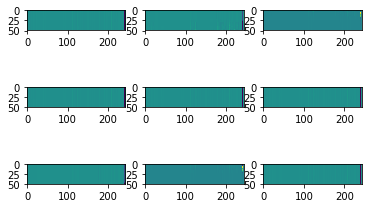

In [12]:
# plot cat photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'ok.' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

CNN Model Baseline Definition

In [56]:
# baseline model for the fail vs ok dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
# plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow_from_directory('dataset_fail_vs_ok/train/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('dataset_fail_vs_ok/test/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)
    model.save('final_feature_model.h5')

# entry point, run the test harness
run_test_harness()

Found 772 images belonging to 2 classes.
Found 227 images belonging to 2 classes.
> 100.000


# Spectrogram-CNN Compilation

In [13]:
# baseline model for the fail vs ok dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
# plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow_from_directory('dataset_spectrogram_fail_vs_ok/train/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('dataset_spectrogram_fail_vs_ok/test/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)
    model.save('final_spectrogram_model.h5')

# entry point, run the test harness
run_test_harness()

Found 14 images belonging to 2 classes.
Found 6 images belonging to 2 classes.
> 100.000


# Test Feature-CNN

In [3]:
# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(200, 200))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 200, 200, 3)
    # center pixel data
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

In [4]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model


# load an image and predict the class
def run_example():
    # load the image
    img = load_image('feature_sample_image.jpg')
    #img = cv2.imread('feature_sample_image.jpg')
    # load model
    model = load_model('final_feature_model.h5')
    # predict the class
    result = model.predict(img)
    print(result[0])



In [5]:
# entry point, run the example
run_example()

[0.]


# Feature and Spectrogram Prediction combined

In [1]:
from keras.models import load_model
from keras.layers import concatenate
from keras.models import Model

from keras.layers import Dense


feature_cnn = load_model('final_feature_model.h5')
spec_cnn = load_model('final_spectrogram_model.h5')
 
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([feature_cnn.output, spec_cnn.output])
 
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(2, activation="relu")(combinedInput)
x = Dense(1, activation="sigmoid")(x)
#x = Dense(1, activation="linear")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
combined_model = Model(inputs=[feature_cnn.input, spec_cnn.input], outputs=x)

/home/neptun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
    # load the image
    img = load_image('spectrogram_sample_image.jpg')
    #img = cv2.imread('feature_sample_image.jpg')
    # load model
    model = load_model('final_spectrogram_model.h5')
    # predict the class
    result = model.predict(img)
    print(result[0])

[1.]


In [7]:
feature_img = load_image('feature_sample_image.jpg')
spec_img = load_image('spectrogram_sample_image.jpg')

# predict the class
result = combined_model.predict([feature_img,spec_img])
print(result[0])

[0.5]


In [5]:
cfdfx_shape= cfdfx.shape
np.zeros(shape=cfdfx_shape[0])
df = cfdfx

print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))

Before shifting
After shifting


,y,APASBA1X__kurtosis,APASBA1X__mean,APASBA1X__mean_second_derivative_central,APASBA1X__skewness
116,0.0,-0.028595,4.905937,-0.002064,0.008114
117,0.0,0.058412,4.484654,-0.000408,0.010970
118,1.0,0.085912,4.460654,0.000636,0.013020
119,1.0,0.028686,4.499861,-0.002047,0.028401
121,0.0,0.079130,4.585782,0.000448,0.026097


In [6]:
# Remove time column, and the categorical columns
#df = df.drop(['time', 'x28', 'x61'], axis=1)

In [7]:
input_X = df.loc[:, df.columns != 'y'].values  # converts the df to a numpy array
input_y = df['y'].values

n_features = input_X.shape[1]  # number of features

In [8]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return X, y

In [9]:
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])
lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)
print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 )))

First instance of y = 1 in the original data


,y,APASBA1X__kurtosis,APASBA1X__mean,APASBA1X__mean_second_derivative_central,APASBA1X__skewness,RMS,Spec_RMS,APASBH1R__kurtosis,APASBH1R__mean,APASBH1R__mean_second_derivative_central,...,Spec_RMS,APSCAG1X__kurtosis,APSCAG1X__mean,APSCAG1X__mean_second_derivative_central,APSCAG1X__skewness,RMS,Spec_RMS,Load_AV,Load_RMS,Speed
113,0.0,0.026967,4.450803,-0.000978,0.000825,49.686496,0.247177,-0.044472,-2.050268,0.000155,...,0.315649,-0.486174,-2.817438,0.000216,-0.006007,8.145825,0.060038,17663.633870,17690.559144,67.166289
114,0.0,0.016864,4.344142,-0.000364,0.016095,50.127123,0.323398,-0.057073,-1.750289,-0.000384,...,0.064930,-0.117923,-2.808199,0.000059,0.000057,7.136216,0.033713,17460.210814,17488.924993,67.489007
115,0.0,0.026502,4.544461,0.001095,-0.009977,52.549149,0.391484,-0.094211,-1.590589,-0.000308,...,0.300024,-0.075692,-2.771545,0.000143,-0.004861,6.278541,0.031972,17568.589600,17590.375996,67.811404
116,0.0,-0.028595,4.905937,-0.002064,0.008114,50.959173,0.199054,0.081378,-1.759640,-0.000017,...,0.606387,-0.084484,-2.735188,0.000180,-0.089859,6.262142,0.036025,17822.009623,17849.511416,68.138747
117,0.0,0.058412,4.484654,-0.000408,0.010970,49.856794,0.197611,0.044306,-2.093469,-0.000086,...,0.140698,0.003510,-2.820898,0.000061,-0.033382,5.828625,0.032534,17343.457183,17368.599817,68.471054
118,1.0,0.085912,4.460654,0.000636,0.013020,49.738260,0.186619,-0.019728,-1.870452,0.000099,...,0.394881,-0.299379,-2.699603,-0.000050,0.062306,6.643330,0.043054,17703.991691,17731.394023,68.803935


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,...,257,258,259,260,261,262,263,264,265,266
0,0.016864,4.344142,-0.000364,0.016095,50.127123,0.323398,-0.057073,-1.750289,-0.000384,0.011100,...,0.064930,-0.117923,-2.808199,0.000059,0.000057,7.136216,0.033713,17460.210814,17488.924993,67.489007
1,0.026502,4.544461,0.001095,-0.009977,52.549149,0.391484,-0.094211,-1.590589,-0.000308,0.041713,...,0.300024,-0.075692,-2.771545,0.000143,-0.004861,6.278541,0.031972,17568.589600,17590.375996,67.811404
2,-0.028595,4.905937,-0.002064,0.008114,50.959173,0.199054,0.081378,-1.759640,-0.000017,-0.009714,...,0.606387,-0.084484,-2.735188,0.000180,-0.089859,6.262142,0.036025,17822.009623,17849.511416,68.138747
3,0.058412,4.484654,-0.000408,0.010970,49.856794,0.197611,0.044306,-2.093469,-0.000086,-0.017969,...,0.140698,0.003510,-2.820898,0.000061,-0.033382,5.828625,0.032534,17343.457183,17368.599817,68.471054
4,0.085912,4.460654,0.000636,0.013020,49.738260,0.186619,-0.019728,-1.870452,0.000099,0.025142,...,0.394881,-0.299379,-2.699603,-0.000050,0.062306,6.643330,0.043054,17703.991691,17731.394023,68.803935


In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [11]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]
X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [12]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [13]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [14]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [15]:
X_train_y0_scaled = scale(X_train_y0, scaler)

In [16]:
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [ 0. -0. -0.  0. -0. -0.  0. -0.  0. -0. -0. -0.  0. -0.  0. -0.  0.  0.
 -0.  0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0. -0.  0.  0.  0.  0.
  0. -0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.
 -0. -0.  0. -0. -0.  0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0. -0.  0.
 -0. -0. -0. -0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0. -0.
 -0.  0.  0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0.  0. -0.
  0. -0.  0. -0. -0.  0.  0.  0. -0.  0. -0.  0. -0.  0. -0. -0.  0. -0.
 -0. -0.  0.  0. -0. -0.  0. -0.  0. -0.  0. -0.  0.  0.  0. -0. -0. -0.
 -0. -0.  0. -0. -0. -0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0.
 -0. -0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0. -0. -0.  0.  0.  0. -0.
 -0.  0. -0.  0. -0. -0.  0. -0. -0. -0. -0. -0.  0. -0.  0.  0. -0. -0.
 -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0. -0. -0.  0.
 -0.  0.  0.  0.  0. -0.  0.  0. -0.  0. -0. -0.  0. -0. -0.  0. -0. -0.
 -0.  0.  0. -0. -0.  0.  0. -0. -0. -

In [17]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)
X_test_scaled = scale(X_test, scaler)

In [18]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59, the number of variables

epochs = 500
batch = 64
lr = 0.0001

In [19]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(timesteps, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(1, activation='relu'))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(timesteps, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 5)              5460      
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 16)             1408      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 72        
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 1)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 5)              140       
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 16)             1408      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 267)            4539      
Total para

In [20]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Train on 401 samples, validate on 101 samples
Epoch 1/500
 - 7s - loss: 1.0219 - val_loss: 0.9881
Epoch 2/500
 - 0s - loss: 1.0219 - val_loss: 0.9881
Epoch 3/500
 - 0s - loss: 1.0219 - val_loss: 0.9881
Epoch 4/500
 - 0s - loss: 1.0219 - val_loss: 0.9881
Epoch 5/500
 - 0s - loss: 1.0219 - val_loss: 0.9881
Epoch 6/500
 - 0s - loss: 1.0219 - val_loss: 0.9881
Epoch 7/500
 - 0s - loss: 1.0219 - val_loss: 0.9881
Epoch 8/500
 - 0s - loss: 1.0218 - val_loss: 0.9880
Epoch 9/500
 - 0s - loss: 1.0218 - val_loss: 0.9880
Epoch 10/500
 - 0s - loss: 1.0218 - val_loss: 0.9880
Epoch 11/500
 - 0s - loss: 1.0218 - val_loss: 0.9880
Epoch 12/500
 - 0s - loss: 1.0218 - val_loss: 0.9880
Epoch 13/500
 - 0s - loss: 1.0218 - val_loss: 0.9880
Epoch 14/500
 - 0s - loss: 1.0218 - val_loss: 0.9880
Epoch 15/500
 - 0s - loss: 1.0218 - val_loss: 0.9880
Epoch 16/500
 - 0s - loss: 1.0218 - val_loss: 0.9880
Epoch 17/500
 - 0s - loss: 1.0218 - val_loss: 0.9880
Epoch 18/500
 - 0s - loss: 1.0218 - val_loss: 0.9880
Epoch 19/

Epoch 154/500
 - 0s - loss: 0.8958 - val_loss: 0.9059
Epoch 155/500
 - 0s - loss: 0.8951 - val_loss: 0.9061
Epoch 156/500
 - 0s - loss: 0.8944 - val_loss: 0.9064
Epoch 157/500
 - 0s - loss: 0.8937 - val_loss: 0.9067
Epoch 158/500
 - 0s - loss: 0.8931 - val_loss: 0.9066
Epoch 159/500
 - 0s - loss: 0.8924 - val_loss: 0.9072
Epoch 160/500
 - 0s - loss: 0.8917 - val_loss: 0.9080
Epoch 161/500
 - 0s - loss: 0.8910 - val_loss: 0.9081
Epoch 162/500
 - 0s - loss: 0.8903 - val_loss: 0.9087
Epoch 163/500
 - 0s - loss: 0.8895 - val_loss: 0.9089
Epoch 164/500
 - 0s - loss: 0.8889 - val_loss: 0.9094
Epoch 165/500
 - 0s - loss: 0.8881 - val_loss: 0.9094
Epoch 166/500
 - 0s - loss: 0.8874 - val_loss: 0.9091
Epoch 167/500
 - 0s - loss: 0.8867 - val_loss: 0.9103
Epoch 168/500
 - 0s - loss: 0.8859 - val_loss: 0.9150
Epoch 169/500
 - 0s - loss: 0.8856 - val_loss: 0.9115
Epoch 170/500
 - 0s - loss: 0.8848 - val_loss: 0.9113
Epoch 171/500
 - 0s - loss: 0.8858 - val_loss: 0.9115
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.8311 - val_loss: 0.8862
Epoch 307/500
 - 0s - loss: 0.8308 - val_loss: 0.8865
Epoch 308/500
 - 0s - loss: 0.8307 - val_loss: 0.8858
Epoch 309/500
 - 0s - loss: 0.8304 - val_loss: 0.8857
Epoch 310/500
 - 0s - loss: 0.8301 - val_loss: 0.8857
Epoch 311/500
 - 0s - loss: 0.8299 - val_loss: 0.8856
Epoch 312/500
 - 0s - loss: 0.8296 - val_loss: 0.8852
Epoch 313/500
 - 0s - loss: 0.8294 - val_loss: 0.8846
Epoch 314/500
 - 0s - loss: 0.8292 - val_loss: 0.8842
Epoch 315/500
 - 0s - loss: 0.8290 - val_loss: 0.8847
Epoch 316/500
 - 0s - loss: 0.8287 - val_loss: 0.8837
Epoch 317/500
 - 0s - loss: 0.8285 - val_loss: 0.8838
Epoch 318/500
 - 0s - loss: 0.8283 - val_loss: 0.8827
Epoch 319/500
 - 0s - loss: 0.8280 - val_loss: 0.8824
Epoch 320/500
 - 0s - loss: 0.8278 - val_loss: 0.8824
Epoch 321/500
 - 0s - loss: 0.8276 - val_loss: 0.8820
Epoch 322/500
 - 0s - loss: 0.8273 - val_loss: 0.8818
Epoch 323/500
 - 0s - loss: 0.8272 - val_loss: 0.8825
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.7945 - val_loss: 0.9318
Epoch 459/500
 - 0s - loss: 0.7942 - val_loss: 0.9325
Epoch 460/500
 - 0s - loss: 0.7941 - val_loss: 0.9328
Epoch 461/500
 - 0s - loss: 0.7939 - val_loss: 0.9351
Epoch 462/500
 - 0s - loss: 0.7936 - val_loss: 0.9347
Epoch 463/500
 - 0s - loss: 0.7935 - val_loss: 0.9362
Epoch 464/500
 - 0s - loss: 0.7932 - val_loss: 0.9368
Epoch 465/500
 - 0s - loss: 0.7931 - val_loss: 0.9378
Epoch 466/500
 - 0s - loss: 0.7932 - val_loss: 0.9369
Epoch 467/500
 - 0s - loss: 0.7929 - val_loss: 0.9370
Epoch 468/500
 - 0s - loss: 0.7928 - val_loss: 0.9350
Epoch 469/500
 - 0s - loss: 0.7925 - val_loss: 0.9352
Epoch 470/500
 - 0s - loss: 0.7923 - val_loss: 0.9371
Epoch 471/500
 - 0s - loss: 0.7922 - val_loss: 0.9387
Epoch 472/500
 - 0s - loss: 0.7923 - val_loss: 0.9385
Epoch 473/500
 - 0s - loss: 0.7919 - val_loss: 0.9366
Epoch 474/500
 - 0s - loss: 0.7918 - val_loss: 0.9386
Epoch 475/500
 - 0s - loss: 0.7913 - val_loss: 0.9409
Epoch 476/500
 - 0s - loss: 

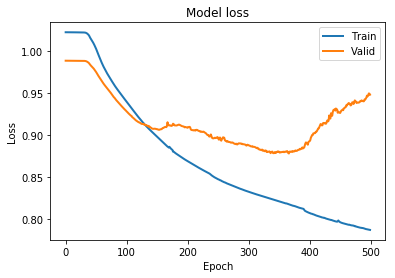

In [21]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

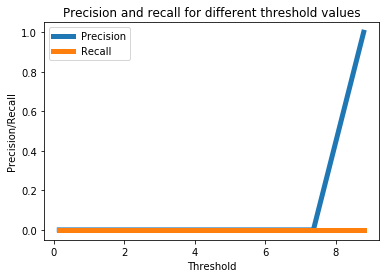

In [22]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

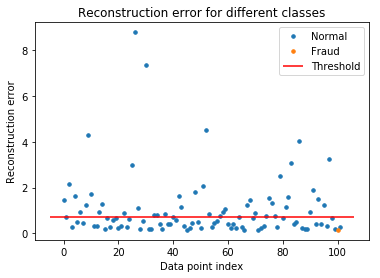

In [23]:
threshold_fixed = 0.7
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

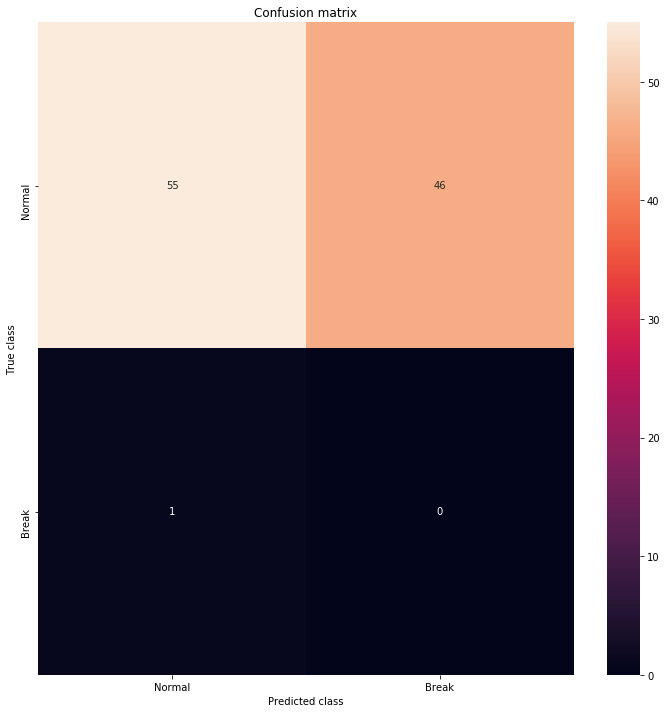

In [24]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

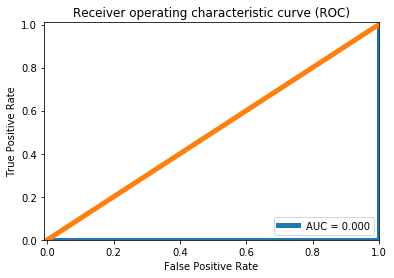

In [25]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()